In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/.kaggle/"

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks/ChestXRay_e-vaid/input')

In [0]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:40<00:00, 103MB/s] 
100% 2.29G/2.29G [00:40<00:00, 60.6MB/s]


In [0]:
!unzip -q chest-xray-pneumonia.zip

In [0]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
print(os.listdir("/content/drive/My Drive/Colab Notebooks/ChestXRay_e-vaid/input/chest_xray/chest_xray/"))

['.DS_Store', 'test', 'train', 'val']


In [0]:
print(os.listdir("/content/drive/My Drive/Colab Notebooks/ChestXRay_e-vaid/input/chest_xray/chest_xray/train/"))

['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [0]:
train_dir = "/content/drive/My Drive/Colab Notebooks/ChestXRay_e-vaid/input/chest_xray/chest_xray/train/"
test_dir = "/content/drive/My Drive/Colab Notebooks/ChestXRay_e-vaid/input/chest_xray/chest_xray/test/"

In [0]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [0]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [0]:
X_train, y_train = get_data(train_dir)

100%|██████████| 3876/3876 [41:46<00:00,  1.55it/s]


In [0]:
X_test, y_test = get_data(test_dir)

100%|██████████| 390/390 [04:08<00:00,  1.57it/s]


In [0]:
print(X_train.shape,'\n',X_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)


In [0]:
print(y_train.shape,'\n',y_test.shape)

(5216,) 
 (624,)


In [0]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [0]:
Pneumonia_images = os.listdir(train_dir + "PNEUMONIA")
Normal_images = os.listdir(train_dir + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


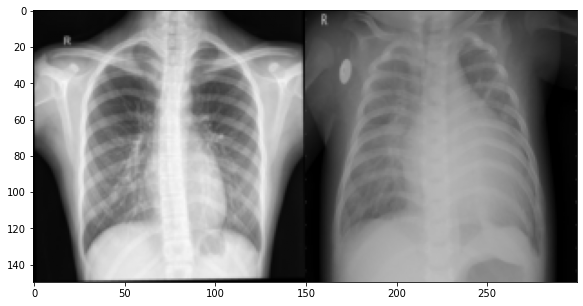

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


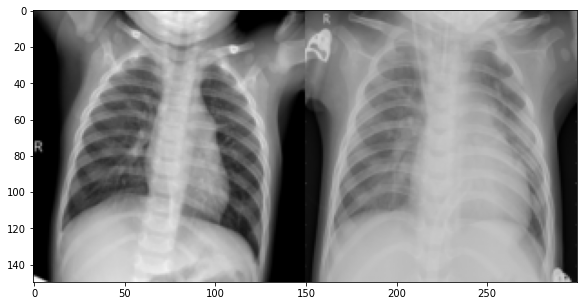

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


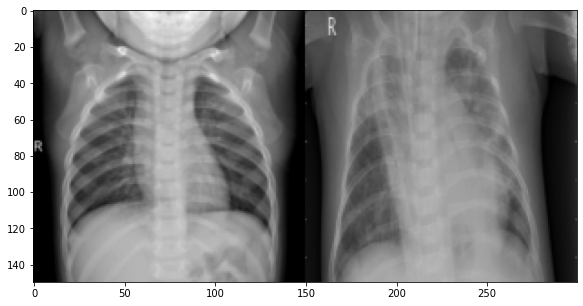

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


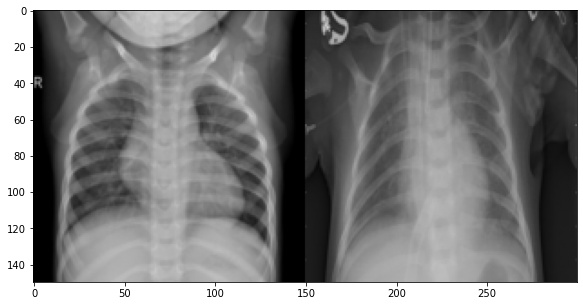

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


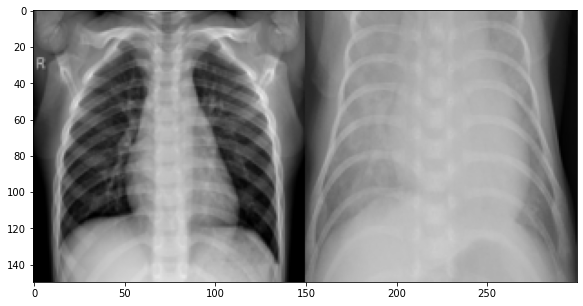

In [0]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(train_dir+"PNEUMONIA/"+Pneumonia_images[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_dir+"NORMAL/"+Normal_images[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [0]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
filepath="my_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [0]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [0]:
X_train=X_train.reshape(5216,150,150,3)
X_test=X_test.reshape(624,150,150,3)


In [0]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False , input_shape=(150, 150, 3))

87916544/87910968 [==============================] - 3s 0us/step


In [0]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)
# model=Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(2,activation='sigmoid'))

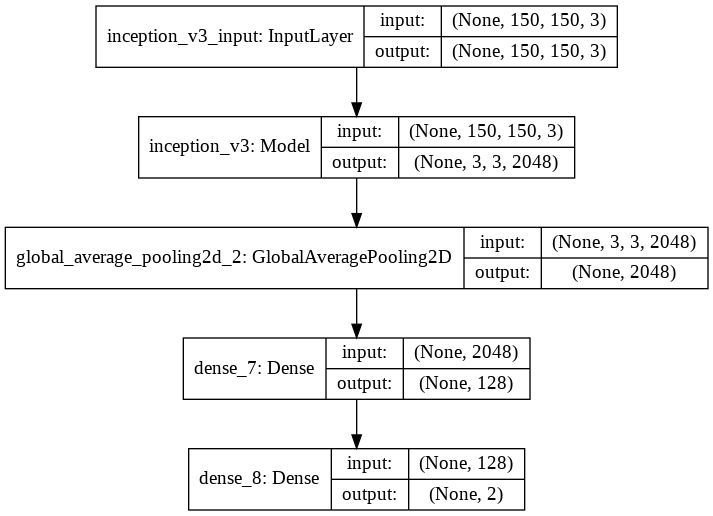

In [0]:
# from keras.utils.vis_utils import model_to_dot
# from IPython.display import Image
# Image(model_to_dot(model, show_shapes=True).create_png())

In [0]:
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [0]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(model, show_shapes=True).create_png())

In [0]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
batch_size = 64
epochs = 10

In [0]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 60s 12ms/step - loss: 0.1344 - accuracy: 0.9450 - val_loss: 0.4887 - val_accuracy: 0.8173

Epoch 00001: val_accuracy improved from -inf to 0.81731, saving model to my_model_weights.h5
Epoch 2/10
5216/5216 [==============================] - 32s 6ms/step - loss: 0.0828 - accuracy: 0.9697 - val_loss: 0.6415 - val_accuracy: 0.8574

Epoch 00002: val_accuracy improved from 0.81731 to 0.85737, saving model to my_model_weights.h5
Epoch 3/10
5216/5216 [==============================] - 32s 6ms/step - loss: 0.0397 - accuracy: 0.9866 - val_loss: 1.3230 - val_accuracy: 0.7388

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_accuracy did not improve from 0.85737
Epoch 4/10
5216/5216 [==============================] - 32s 6ms/step - loss: 0.0195 - accuracy: 0.9923 - val_loss: 1.1784 - val_accuracy: 0.7756

Epoch 00004: ReduceLROnPlateau reducing le

In [0]:
# model.save_weights('my_model_weights.h5')

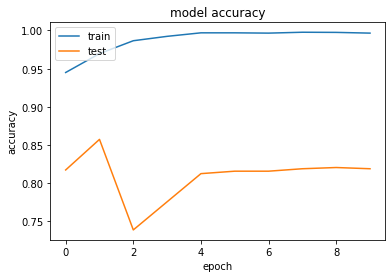

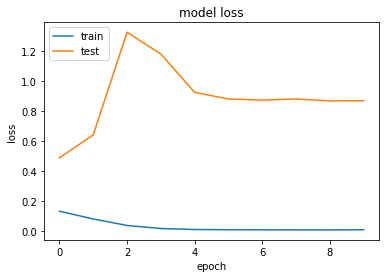

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

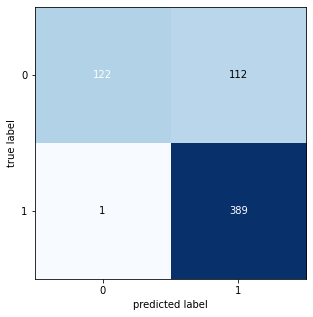

In [0]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()


Precision

In [0]:
389 / (389 + 112)

0.7764471057884231

Recall

In [0]:
389 / (389 + 1)

0.9974358974358974

F1-Score

In [0]:
2*0.9974*0.7764 / (0.9974 + 0.7764)

0.8731326643364526

In [0]:

pred=model.predict(X_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break


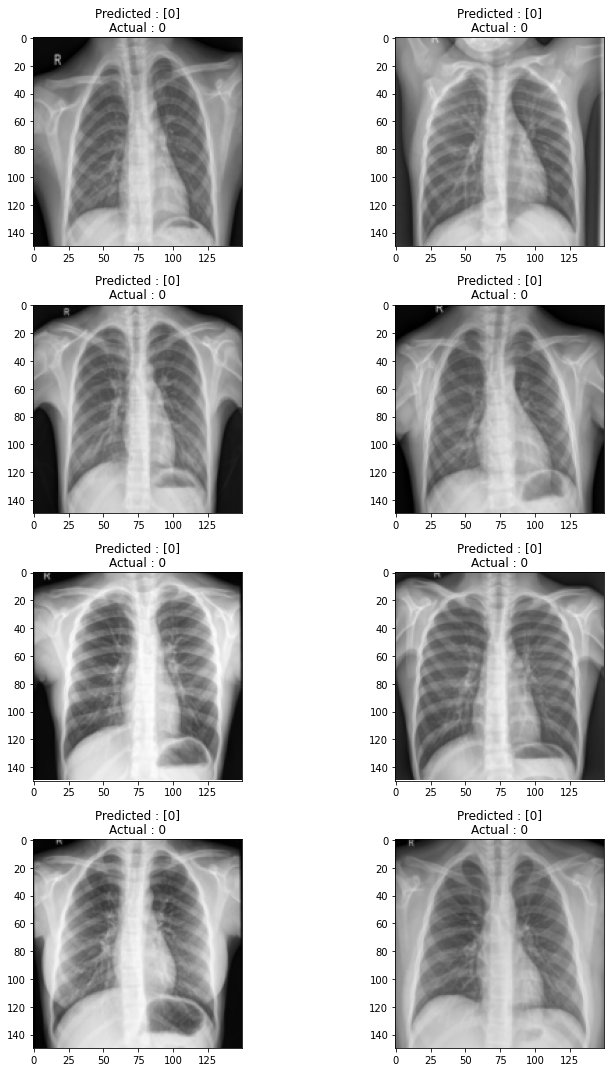

In [0]:

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[prop_class[count]])
        ax[i,j].set_title("Predicted : "+str([pred_digits[prop_class[count]]])+"\n"+"Actual : "+str(np.argmax([y_test[prop_class[count]]])))
        plt.tight_layout()
        count+=1

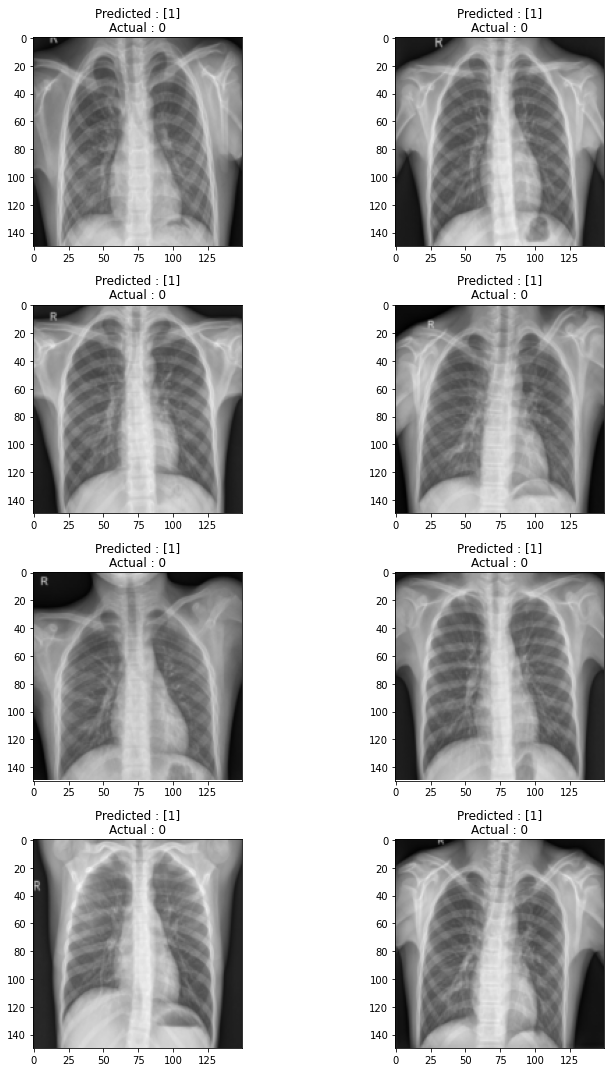

In [0]:


count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test[mis_class[count]])
        ax[i,j].set_title("Predicted : "+str([pred_digits[mis_class[count]]])+"\n"+"Actual : "+str(np.argmax([y_test[mis_class[count]]])))
        plt.tight_layout()
        count+=1